In [1]:
%gui wx
%load_ext autoreload
%autoreload 2
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading fsl and freesurfer within Neurodesk
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

from utils import loadFSL, FSLeyesServer, mkdir_no_exist

# FSL function wrappers which we will call from python directly
loadFSL() # Setup FSL path
from fsl.wrappers import bet, fslmaths

import nibabel as nib
import nilearn
import subprocess
import openneuro

from nilearn import image 
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.image import mean_img
from nilearn.input_data import NiftiMasker

from sklearn.decomposition import PCA

from IPython.display import Image


from preprocessed import viz_fsleyes, get_skull_stripped_anatomical, apply_fsl_mask
from preprocessed import concatenate_mri_runs, plot_bold_data, plot_mean_voxel_intensity, apply_mcflirt, load_mot_params_fsl_6_dof, apply_slice_timer, compute_FD_power
from GLM import reg_motion, get_conditions_of_interest, atlas_fMRI_MNI, make_combined_mask_from_aal


In [2]:
dataset_id = 'ds000171'
subject = "sub-control01"
task = 'music'

current_dir = os.path.abspath("")
dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')
mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)

In [3]:
viz = False # if false no fsleyesDisplay vizualisations will be displayed

if viz:
    fsleyesDisplay = FSLeyesServer()
    fsleyesDisplay.show()
else:
    fsleyesDisplay = None

# Anatomical Preprocessing

### Overview of the anatomical 

In [4]:
anatomical_path = op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject)
viz_fsleyes(fsleyesDisplay, [anatomical_path], viz=viz)

## Skull removal using bet

In [5]:
resulting_mask = get_skull_stripped_anatomical(dataset_path, preproc_path, subject, robust=True)
viz_fsleyes(fsleyesDisplay, [anatomical_path, resulting_mask], viz=viz)

Done with BET.


In [6]:
betted_brain_path = apply_fsl_mask(dataset_path, resulting_mask, preproc_path, subject)
viz_fsleyes(fsleyesDisplay, [anatomical_path, betted_brain_path], viz=viz)

Mask applied


# fMRI Preprocessing

## Field Stabilisation

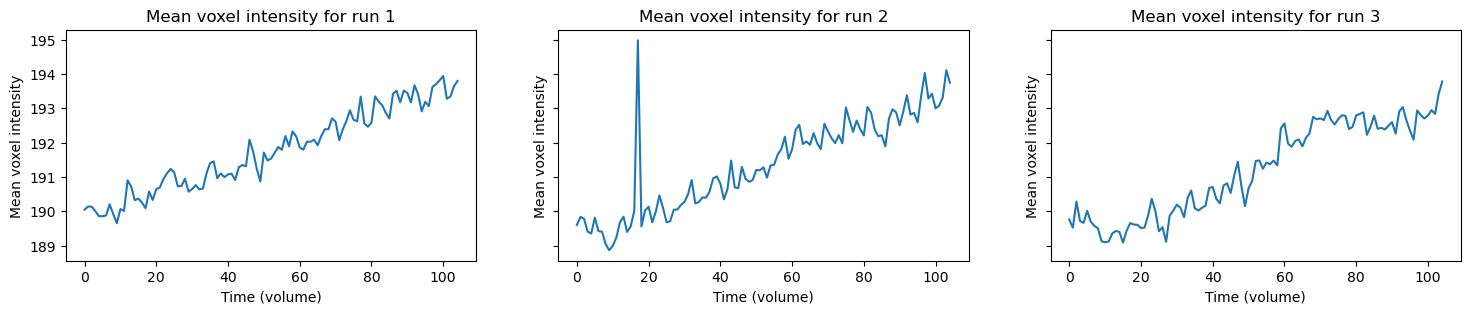

In [7]:
fig,axs = plt.subplots(1,3, sharey = True, figsize= (18,3))
for i in range(3):
    run_i = op.join(dataset_path, subject,'func',f'sub-control01_task-music_run-{i+1}_bold.nii.gz')
    axs[i].plot(nib.load(run_i).get_fdata().mean(axis=(0,1,2)))
    axs[i].set_xlabel('Time (volume)')
    axs[i].set_ylabel('Mean voxel intensity')
    axs[i].set_title(f'Mean voxel intensity for run {i+1}')
plt.show()

Field Stabilisation does not seem necessary

## Standardization and run concatenation

In [8]:
all_runs = concatenate_mri_runs(dataset_path, preproc_path, subject, task, fct= 'zscore')
viz_fsleyes(fsleyesDisplay, [all_runs], viz=viz) # look at volume 122 !!

Concatenation complete. 
Output saved to /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold.nii.gz


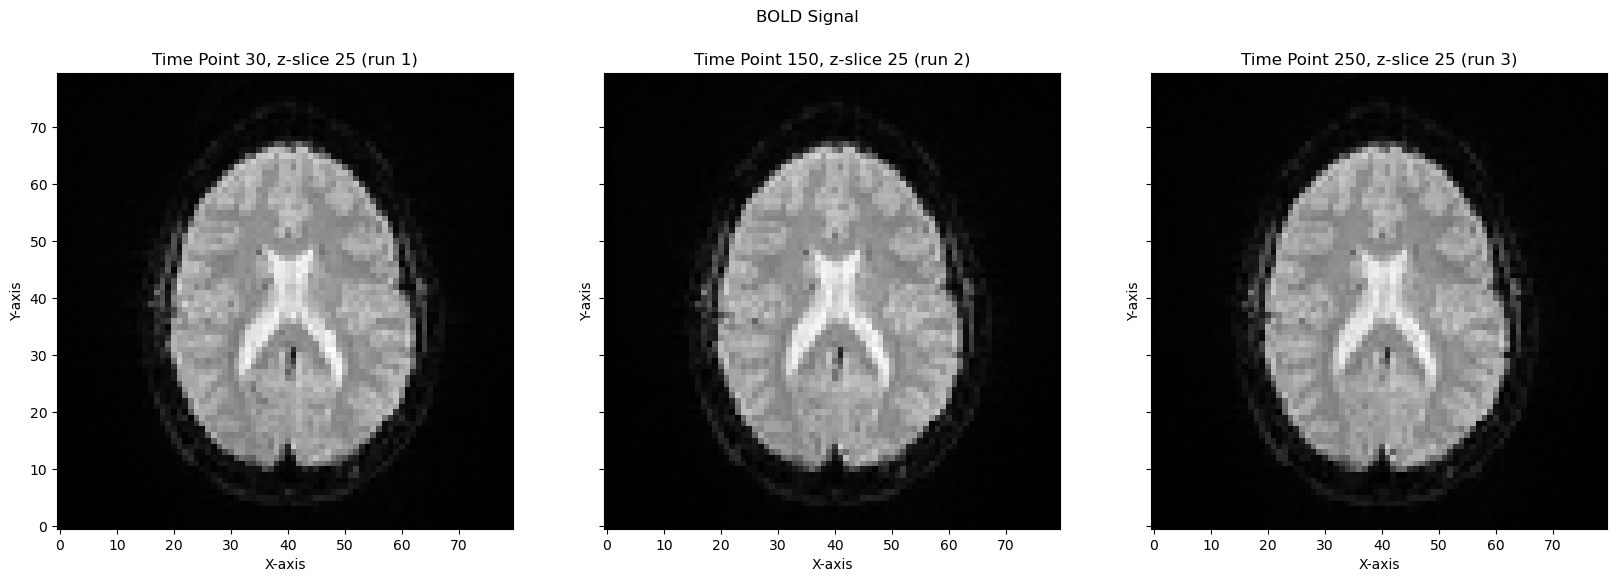

In [9]:
plot_bold_data(all_runs, timepoints=[30,150,250])

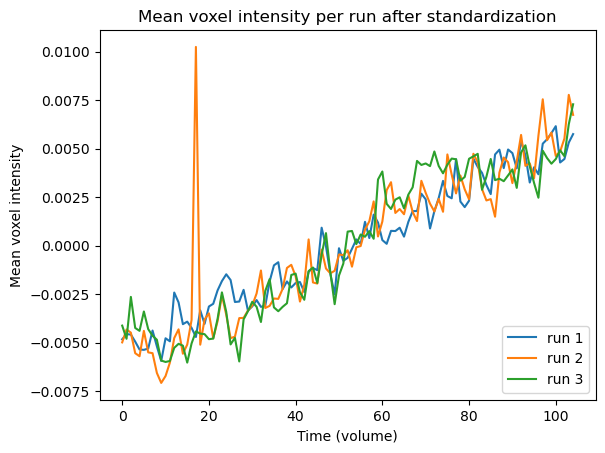

In [10]:
plot_mean_voxel_intensity(all_runs, len_run = 105)

## Motion correction

In [11]:
run = 'all'
path_moco_data, reference_moco = apply_mcflirt(preproc_path, subject, task, run)
viz_fsleyes(fsleyesDisplay, [path_moco_data, reference_moco], viz=viz) 

Processed data will be saved as /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][29

In [12]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold_moco.par'.format(subject, task, "all")))
display(mot_params)
print('There is basically no frame displacement above 0.2mm (if looking only along X translation)!')

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003651,0.002704,0.000000e+00,-0.038644,-0.502657,-0.452693
1,-0.003541,0.002544,0.000000e+00,-0.050817,-0.472560,-0.448338
2,-0.003508,0.002627,2.469330e-04,-0.038808,-0.459388,-0.434871
3,-0.003245,0.002794,1.694070e-21,-0.038591,-0.458648,-0.450840
4,-0.003189,0.002751,0.000000e+00,-0.054403,-0.458174,-0.470786
...,...,...,...,...,...,...
310,0.009202,-0.000126,-1.873470e-03,-0.066892,0.414630,0.281888
311,0.009253,-0.000566,-1.809340e-03,-0.054452,0.398779,0.265088
312,0.009223,-0.000687,-1.709950e-03,-0.066652,0.424857,0.261962
313,0.008878,-0.000743,-1.982520e-03,-0.079571,0.400954,0.248427


There is basically no frame displacement above 0.2mm (if looking only along X translation)!


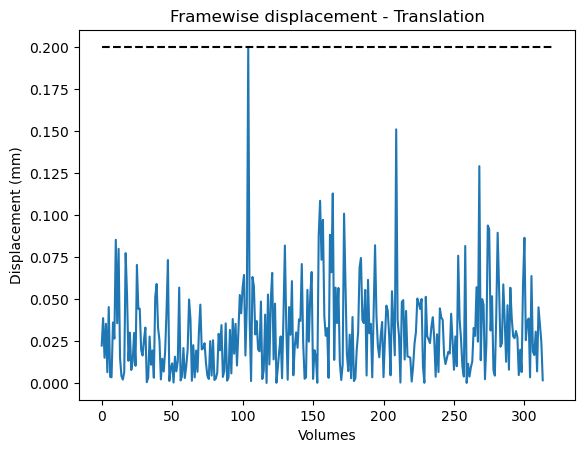

The following frames have a FWD above threshold :  [104]


In [13]:
#compute cumulated absolute translation
trans = np.abs(mot_params["Translation x"]) + np.abs(mot_params["Translation y"]) + np.abs(mot_params["Translation z"])
# Compute distance with respect to previous frame (displacement)
disp = np.diff(trans)
threshold=0.2

plt.plot(abs(disp))
plt.hlines(threshold, 0, 320, colors='black', linestyles='dashed', label='FD threshold')
plt.title("Framewise displacement - Translation")
plt.xlabel("Volumes")
plt.ylabel("Displacement (mm)")
plt.show()
trans_thr =np.abs(disp)>threshold
print("The following frames have a FWD above threshold : ", np.where(trans_thr)[0])

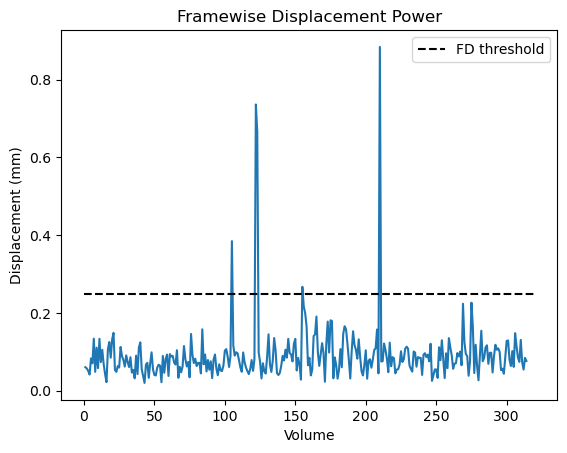

The following frames have a FD power above threshold :  [104 121 122 154 209]


In [14]:
fd = compute_FD_power(mot_params).to_numpy()
threshold = np.mean(fd) + 2 * np.std(fd)

plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('Displacement (mm)')
plt.title("Framewise Displacement Power")
plt.hlines(threshold, 0, 320,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()
FD_thr = np.abs(fd)>threshold
print("The following frames have a FD power above threshold : ", np.where(FD_thr)[0])

## Slice Time correction

In [15]:
data = pd.read_json(op.join(dataset_path, 'task-{}_bold.json'.format(task)), typ= 'series')
slice_timing = data['SliceTiming']
tr = data['RepetitionTime'] 

In [16]:
# Get header information - to determine the number of slices
#print(os.system('fslhd {}'.format(op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz'))))
#print('The dimension on which the slides are should have length ~', len(slice_timing)) 
# ----> Dimension of the slices here is the z dimension so we give dim  = 3 to slicetimer below 

In [17]:
file_to_realign = op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz')
slice_corrected = apply_slice_timer(preproc_path, subject, task, run, file_to_realign, slice_timing, tr, dim=3)
viz_fsleyes(fsleyesDisplay, [slice_corrected], viz=viz)

## Smoothing

In [18]:
mkdir_no_exist(op.join(preproc_path, subject, 'func', 'final'))
smooth_voxel = 9 #mm
output_path = op.join(preproc_path, subject, 'func', 'final', f'sub-control01_task-music_run-all_bold_smoothed-{smooth_voxel}mm')

subprocess.run(['fslmaths', slice_corrected, '-s', str(smooth_voxel/2.3548), output_path])

CompletedProcess(args=['fslmaths', '/data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_slice-corr', '-s', '3.8219806352981145', '/data/data/derivatives/preprocessed_data/sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-9mm'], returncode=0)

In [19]:
viz_fsleyes(fsleyesDisplay, [output_path], viz=viz)

# GLM

## Read the events and data

In [20]:
events = {}
for i in range(1,4):
    events[i] = pd.read_csv(os.path.join(dataset_path, subject,"func",f"sub-control01_task-music_run-{i}_events.tsv"), sep = "\t")
    if i>1: #adjust onset time for concatenation
        events[i]['onset'] += (events[i-1]['onset'].iloc[-1] + events[i-1]['duration'].iloc[-1])

events_concat = pd.concat(events.values(),ignore_index=True)
display(events_concat)
events_concat.to_csv(op.join(deriv_path, 'events_concat.csv'))

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [21]:
fmri_img = nib.load(op.join(preproc_path,"sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-9mm.nii.gz"))
print(fmri_img.shape)

n_scans = fmri_img.get_fdata().shape[-1]
frame_times = np.arange(n_scans) * tr

(80, 80, 50, 315)


## Design matrix

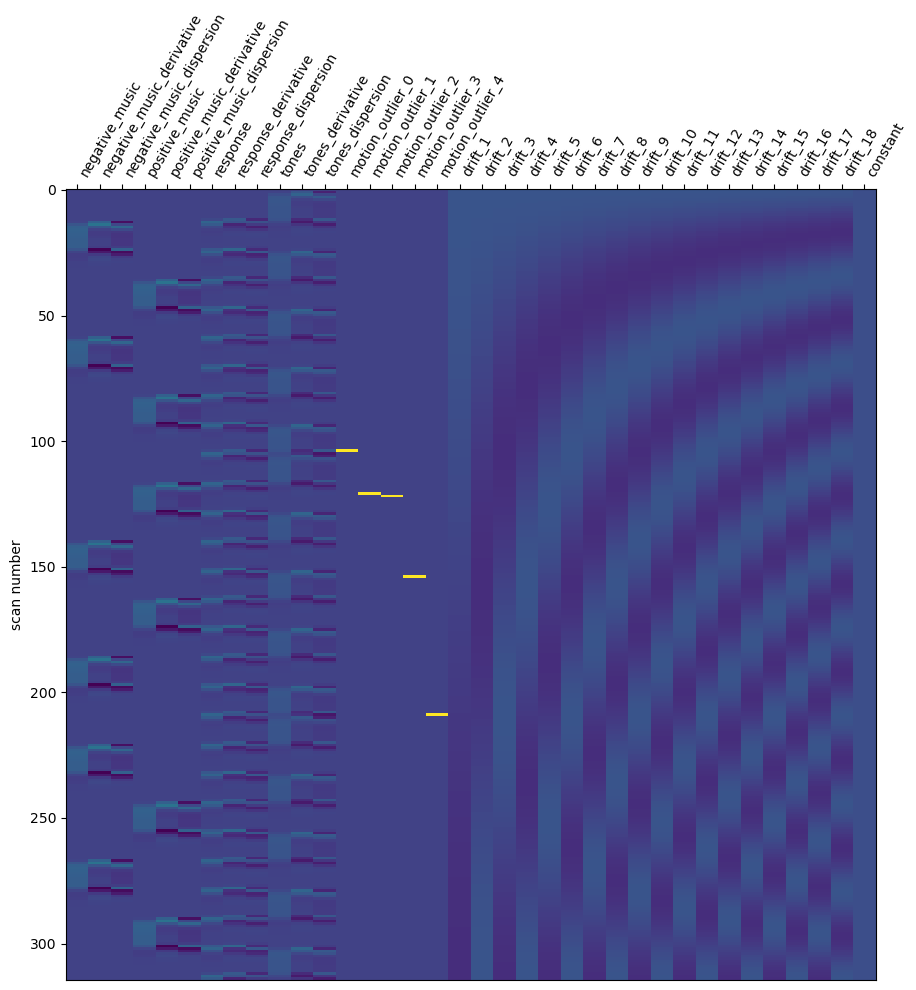

In [22]:
# Take into account motion outliers based on the FD threshold
motion_outliers = np.where(FD_thr)[0]
new_regs, new_reg_names = reg_motion(motion_outliers, n_scans)

design = make_first_level_design_matrix(frame_times = frame_times,
                                        events= events_concat, 
                                        hrf_model='spm + derivative + dispersion',
                                        drift_model="cosine",
                                        high_pass = .01,
                                        add_regs = new_regs.T,
                                        add_reg_names = new_reg_names)

plot_design_matrix(design,rescale=False, output_file = op.join(deriv_path, 'design_matrix.jpg'))
plot_design_matrix(design, rescale=True)
plt.show()

In [23]:
fmri_glm = FirstLevelModel(t_r = tr, 
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm + derivative + dispersion',
                           drift_model="cosine",
                           high_pass=.01)

fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design])

### Statistical maps of regressors

In [24]:
to_show = [x for x in np.arange(-30,40,10)]
z_threshold = 1.5

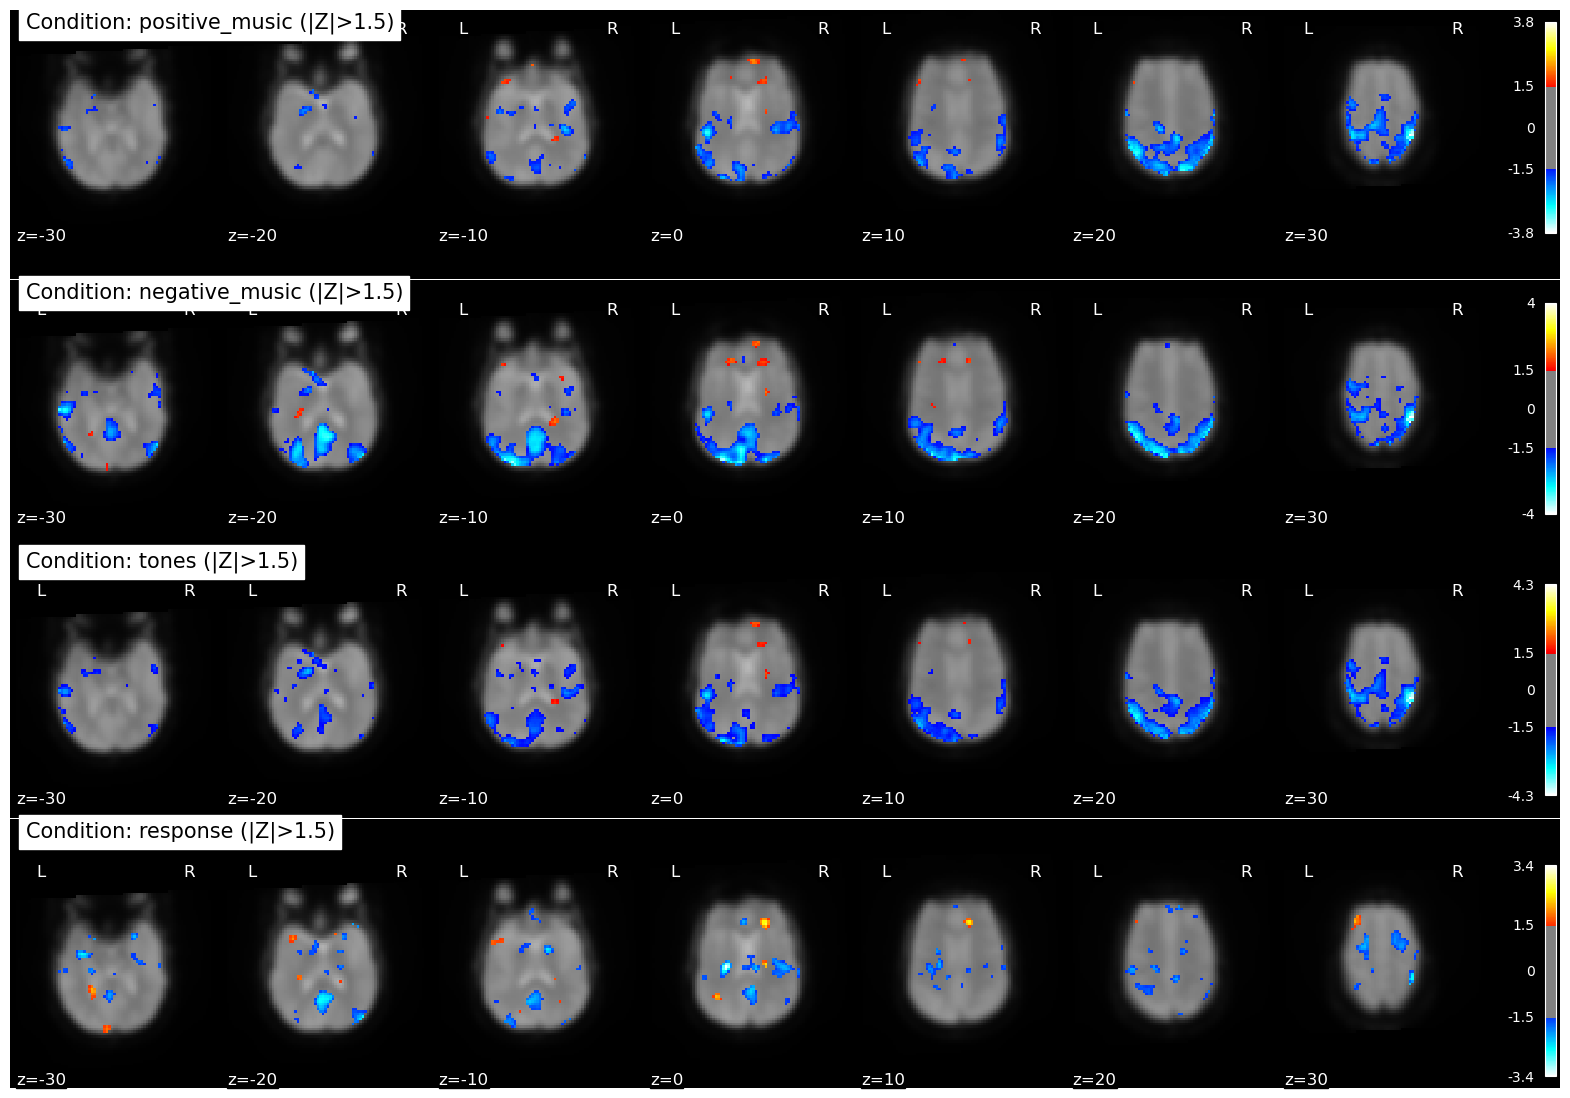

In [25]:
# Define keys to filter conditions of interest
keys_to_keep = ['positive_music', 'negative_music', 'tones', 'response']
conditions_of_interest = get_conditions_of_interest(design, keys_to_keep)

# Show statistical maps of regressors of interest
betas_zmap = op.join(preproc_path,'betas_zmap')
mkdir_no_exist(betas_zmap)

cluster_size = 1 #number of voxels for a cluster to be kept
fdr_rate = 0.05 # alpha = 5%

mean_img = mean_img(fmri_img)
fig, axs = plt.subplots(len(conditions_of_interest), 1, figsize=(20,14))
for i, (key,value) in enumerate(conditions_of_interest.items()):
    z_map = fmri_glm.compute_contrast(value, output_type='z_score')
    
    plot_stat_map(z_map,
                  bg_img=mean_img,
                  threshold=z_threshold,
                  display_mode='z',
                  cut_coords=to_show,
                  black_bg=True,
                  title='Condition: {} (|Z|>{})'.format(key, z_threshold),
                  axes = axs[i])
    
plt.subplots_adjust(wspace=0, hspace=0)
output_plot_path = 'data/derivatives/all_cdts_9mm.png'
plt.savefig(output_plot_path, format='png')
plt.show()

## Contrast

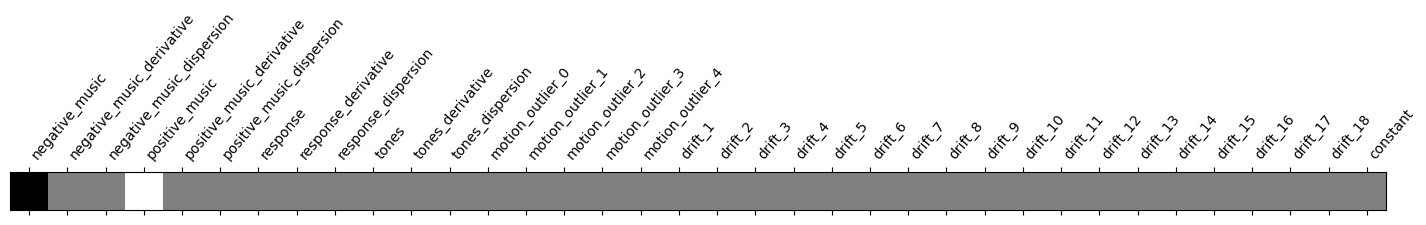

In [26]:
# We are interested in the difference between positive and negative music effects
pos_vs_neg = conditions_of_interest['positive_music'] - conditions_of_interest['negative_music']

plot_contrast_matrix(pos_vs_neg, design_matrix=design, output_file = op.join(deriv_path, 'contrast_pos_neg.jpg'))
plot_contrast_matrix(pos_vs_neg, design_matrix=design)
plt.show()

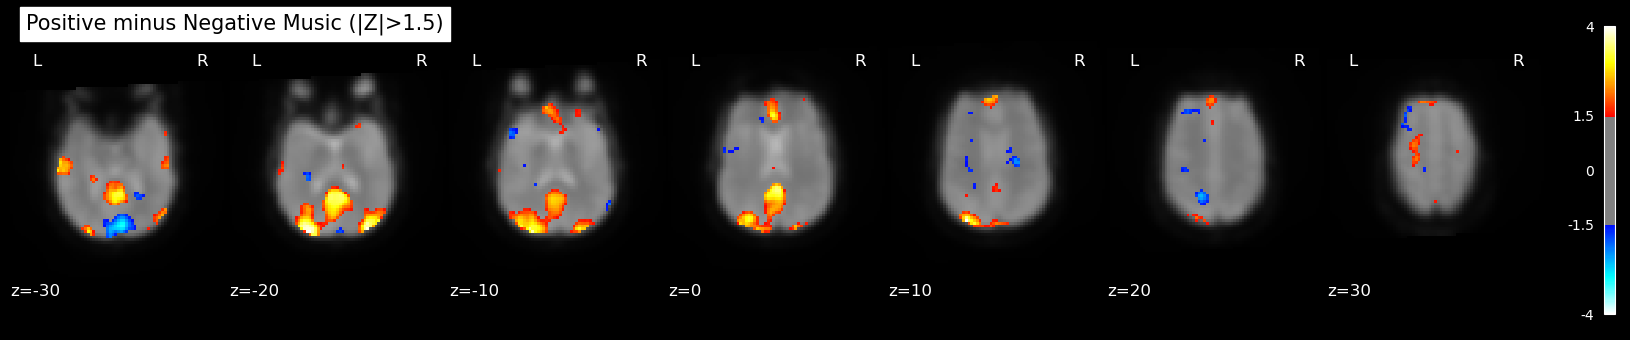

In [27]:
z_map = fmri_glm.compute_contrast(pos_vs_neg, output_type='z_score')

plot_stat_map(z_map,
              bg_img=mean_img,
              threshold=z_threshold,
              display_mode='z',
              cut_coords=to_show,
              black_bg=True,
              title='Positive minus Negative Music (|Z|>{})'.format(z_threshold))

output_plot_path = 'data/derivatives/contrast_9mm.png'
plt.savefig(output_plot_path, format='png')
plt.show()

In [28]:
atlas_path = "data/derivatives/atlas_template.nii"
fMRI_MNI_path = op.join(preproc_path,"sub-control01/func/sub-control01_task-music_run-all_bold_moco_MNI.nii")

atlas_img, fMRI_MNI = atlas_fMRI_MNI(fmri_img, atlas_path, fMRI_MNI_path, preproc_path)

In [29]:
viz_fsleyes(fsleyesDisplay, [atlas_path], viz=viz)

Saved combined mask as data/derivatives/atlas_combined_mask.nii.gz


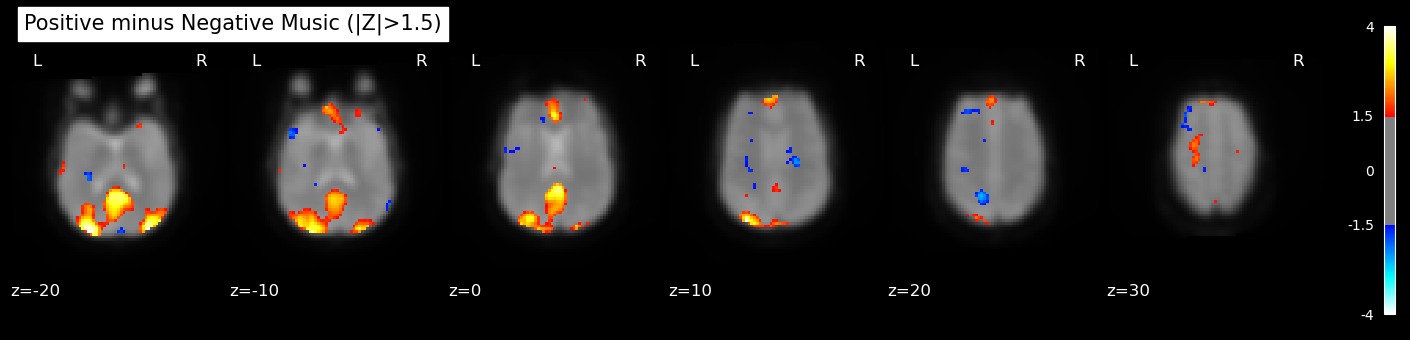

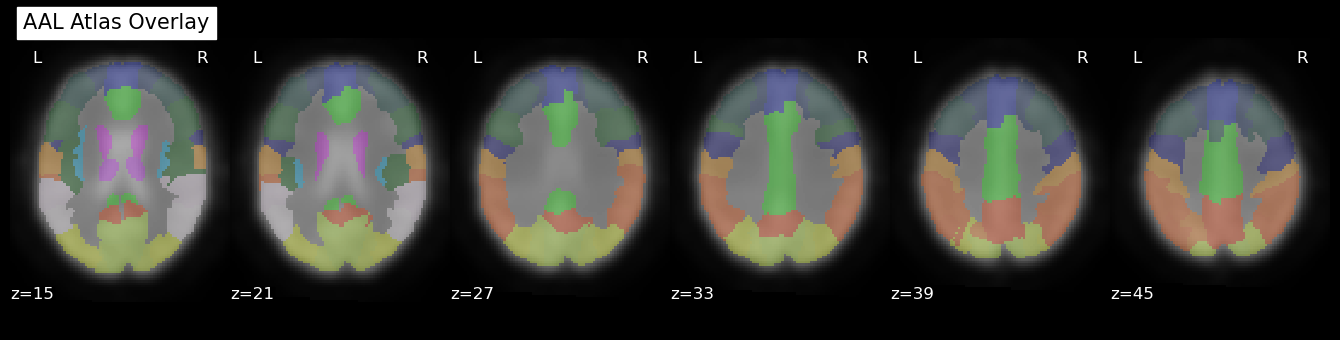

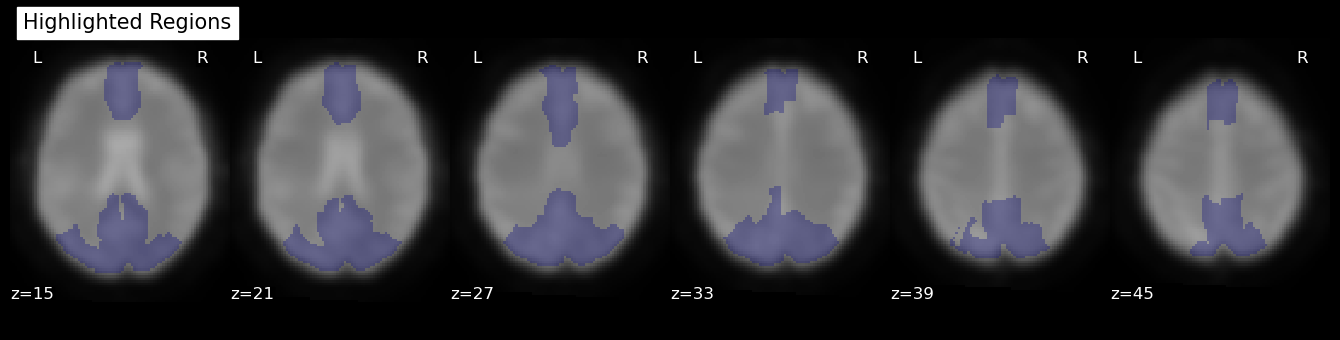

In [31]:
# List of labels corresponding to regions of interest
mask_values = [6301, 6302, 5001, 5002, 5011, 5012, 5101, 5102, 5201, 5202, 4021, 4022, 2601, 2602, 4001, 4002] 
combined_mask_name = "data/derivatives/atlas_combined_mask.nii.gz"
from nilearn.image import mean_img

make_combined_mask_from_aal(atlas_img, mask_values, combined_mask_name)

mean_img = mean_img(fmri_img)
plot_stat_map(z_map,
              bg_img=mean_img,
              threshold=z_threshold,
              display_mode='z',
              cut_coords=[z for z in np.arange(-20,40,10)],
              black_bg=True,
              title='Positive minus Negative Music (|Z|>{})'.format(z_threshold))

# Since images are not coregistered, we looked for similar z axis
plot_roi(atlas_img,
        bg_img=fMRI_MNI,
        display_mode='z',
        cut_coords=[z for z in np.arange(15,50,6)],
        alpha=0.3,
        title="AAL Atlas Overlay")

plot_roi(combined_mask_name,
        bg_img=fMRI_MNI,
        display_mode='z',
        cut_coords=[z for z in np.arange(15, 50, 6)],
        alpha=0.3,
        title="Highlighted Regions")

plt.show()

# PCA

In [32]:
save_results = op.join(current_dir, 'data/derivatives/pca_results/')
if not os.path.exists(save_results):
    os.makedirs(save_results)

## PCA Preprocessing

In [33]:
data = np.asanyarray(fmri_img.dataobj)
affine = fmri_img.affine
vol_shape =  data.shape[:3]
n_vols = data.shape[-1]

In [34]:
# After visualizing the data we concluded that backgrounds voxels have 0 or negative values
slice_non_background = data[:,:,:,0] > 0
samples = data[slice_non_background,:].T
samples.shape

(315, 71798)

In [35]:
spatial_means = np.mean(samples,axis=1)
row_means = np.mean(samples,axis=0)
# Subtract for each timepoint the spatial mean
X = samples - row_means

print(spatial_means.shape)
print(row_means.shape)
print(X.shape)

(315,)
(71798,)
(315, 71798)


## PCA extraction

In [36]:
# Initial number of components, to be invastigated
nb_components = 10
pca = PCA(n_components=nb_components)
pca.fit(X)

PCA(n_components=10)

Explained variance given threshold: 80.68%


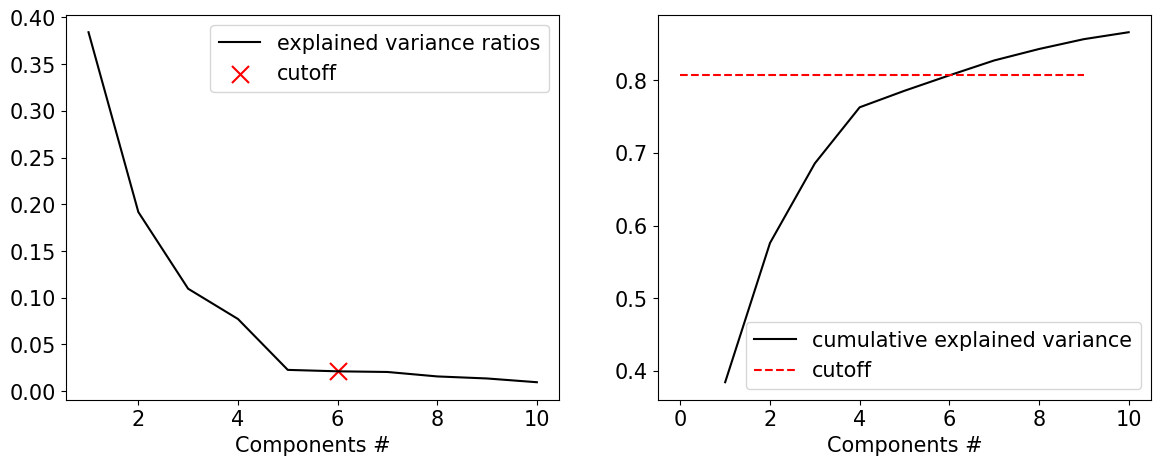

In [37]:
# Select the number of components corresponding to 80% of cumulative explained variance

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)

thresh_dict = dict(zip(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios))
thresh = 0.80
idxs = [idx for idx, val in thresh_dict.items() if val > thresh]
nb_clusters = idxs[0]

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

print("Explained variance given threshold: {:.2%}".format(cumulative_ratios[nb_clusters-1]))

In [38]:
pca_dims = np.zeros((nb_clusters,
                     vol_shape[0],
                     vol_shape[1],
                     vol_shape[2]))

pca_dims[:,slice_non_background] = pca.components_[:nb_clusters] 

In [39]:
# Need the mask to remove the eyes, otherwise the PCA focus on them
mask_path = op.join(current_dir, "data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask.nii.gz")
mask = nib.load(mask_path)
masker = NiftiMasker(mask_img=mask, target_affine=affine)

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


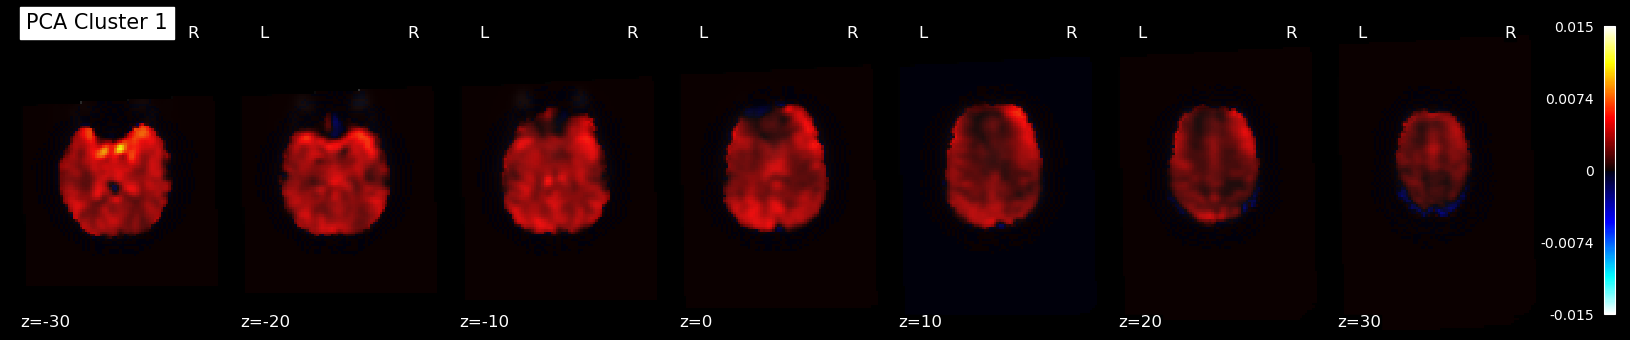

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


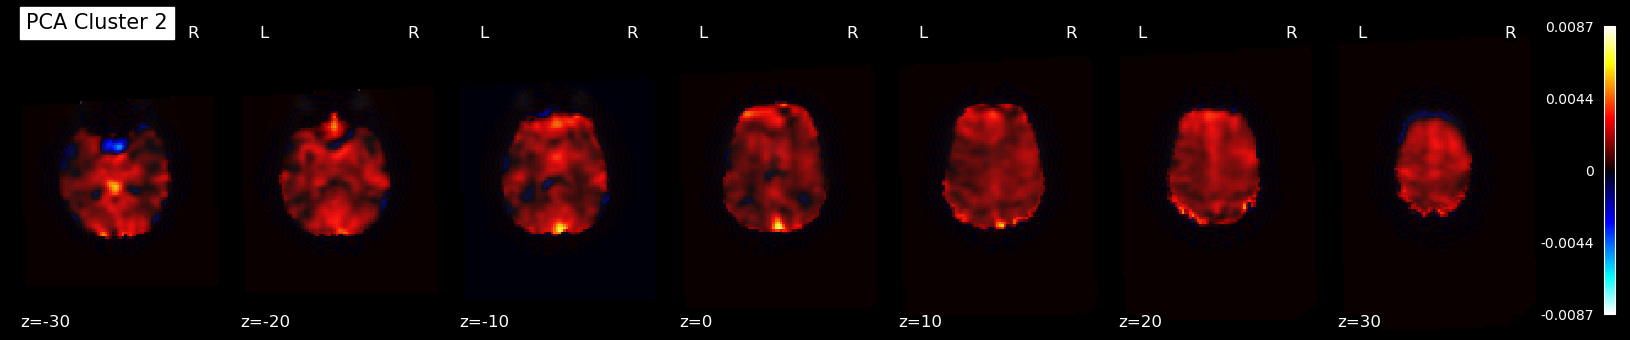

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


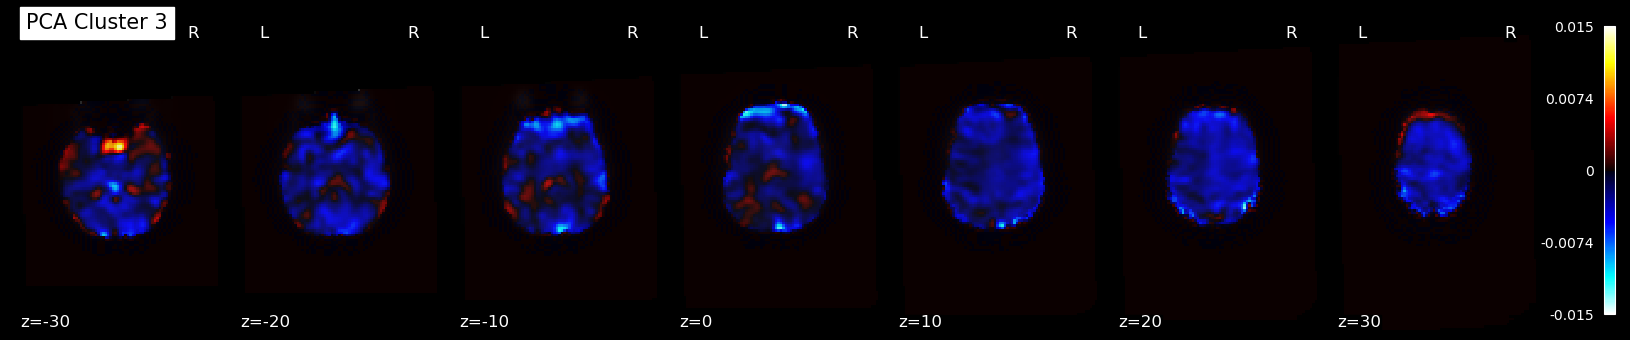

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


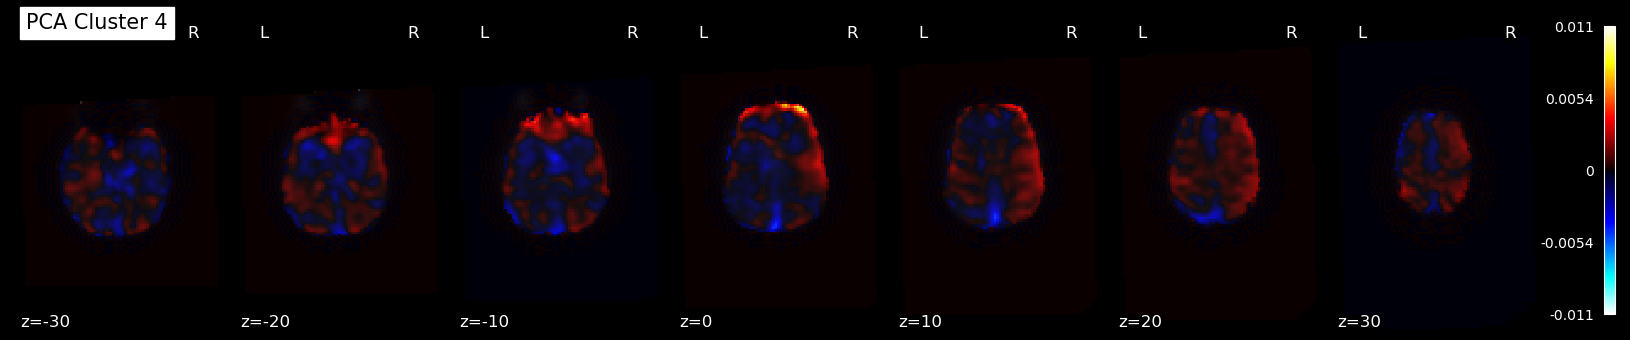

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


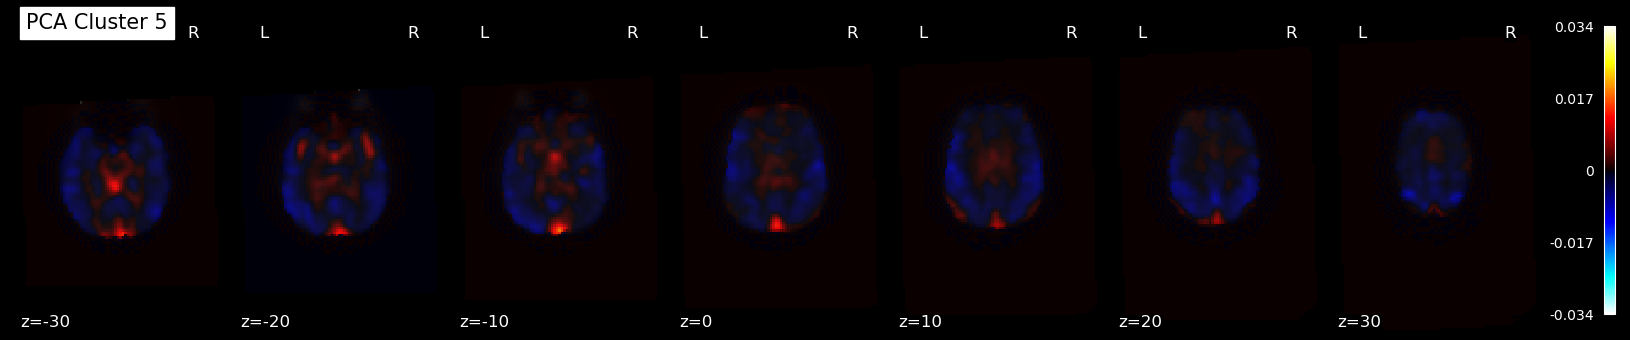

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


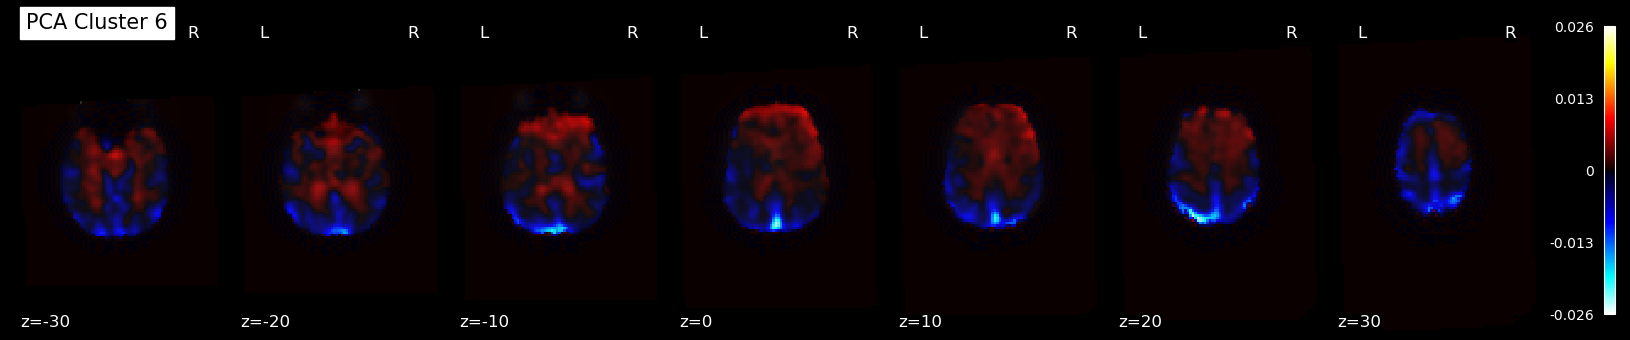

In [40]:
for visual_idx in range(nb_clusters):
    img = nib.Nifti1Image(pca_dims[visual_idx], affine)
    data = masker.fit_transform(img)
    masked = masker.inverse_transform(data)
    plot_stat_map(masked,
                  threshold=0,
                  display_mode='z',
                  cut_coords=to_show,
                  black_bg=True,
                  alpha=0.9,
                  bg_img=mean_img,
                  title=f'PCA Cluster {visual_idx+1}')
    plt.savefig(op.join(save_results,f'pc{visual_idx+1}.png'))
    plt.show()